In [1]:
# set up path to facenet_pytorch_c
import sys
sys.path.insert(1, '/home/ubuntu/mtcnn')

In [2]:
# facenet_pytorch_c: avoid confusion with system default facenet_pytorch
from facenet_pytorch_c import MTCNN

from tqdm import tqdm
import numpy as np
import os

# pytorch
import torch
import torch.optim as optim
from torch import nn

# data handling
from torch.utils.data import DataLoader

# torchvision libs
from torchvision import datasets
from torchvision import transforms

# other custom scripts
import utils

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Available device: " + str(device))

# training hyperparameters
learning_rate = 1e-3
epochs = 30
decay_step = [15]
decay_rate = 0.1
opt = 'Adam'    # either Adam or SGD
batch_size = 64


Available device: cuda:0


In [4]:
# data loading parameters
workers = 4
resize_shape = (224, 224)

In [5]:
# get data
x_train, age_train, fn_train, bbox_train, prob_train, land_train, x_valid, age_valid, fn_valid, bbox_valid, prob_valid, land_valid = utils.get_images(
    r'/home/ubuntu/UTKFace', resize_shape=resize_shape
)

100%|██████████| 5/5 [00:00<00:00, 77.10it/s]

Ignored: 


In [6]:
# setup mtcnn
"""
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, keep_all=True,
    device=device
)
"""
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.5, 0.7, 0.7], factor=0.709, post_process=True, keep_all=True,
    device=device
)

In [10]:
# define data reader

# no need to convert to PIL, because get_images already does that
# also, disabling image normalization for now

# note: horizontal flip must be disabled, or else mtcnn bbox labels would be invalidated

transform_train = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])



transform_valid = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_ds = utils.UTK_dataset(
        x_train, age_train, bbox_train, prob_train,
        land_train, trsfm=transform_train
    )


train_loader = DataLoader(
    train_ds,
    batch_size=batch_size, num_workers=workers, shuffle=True
)


valid_loader = DataLoader(
    utils.UTK_dataset(
        x_valid, age_valid, bbox_valid, prob_valid,
        land_valid, trsfm=transform_valid
    ),
    batch_size=batch_size, num_workers=workers, shuffle=False
)


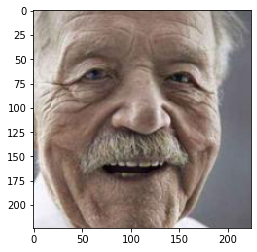

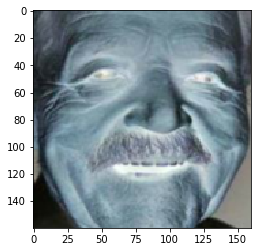

In [11]:
# This cell is for debugging the dataset / dataloader

import matplotlib.pyplot as plt
import torchvision
import PIL

s = train_ds[0]
plt.imshow(torchvision.transforms.ToPILImage()(s[0]))
plt.show()

sys.path.insert(1, '/home/ubuntu/mtcnn/facenet_pytorch_c/models/utils')
import detect_face

img = detect_face.extract_face(torchvision.transforms.ToPILImage()(s[0]), s[2])
plt.imshow(torchvision.transforms.ToPILImage()(img))
plt.show()
